# Bayesian Trust Learning for LLM Routing: Teaching Routers to Learn from Their Mistakes
Or: How We Taught Our Router to Stop Worrying and Learn to Love Production Feedback

## The Question That Started It All

Picture this: It's 3 AM. Your support system just routed a critical database corruption ticket to Claude Haiku (the $0.25/million token model) because it looked "simple enough." Six hours and three escalations later, your biggest client is furious, and you're wondering why your "intelligent" router keeps making the same mistakes.

Meanwhile, across town, your competitor is sending every single ticket to GPT-4 "just to be safe," burning through $100,000 monthly for questions like "how do I reset my password?"

There has to be a better way. And there is—but it involves teaching your router something most systems never learn: humility.

## The Routing Revolution (and Its Dirty Little Secret)

The LLM routing world has come a long way! OpenRouter elegantly handles 400+ models behind one API (processing over $100M in inference annually), while RouteLLM demonstrates impressive ~85% cost reductions on benchmarks. These are genuinely great tools that have solved real problems.
But here's the thing they don't really learn if they were right.

Imagine having a waiter who keeps recommending the "chef's special ghost pepper curry" to people who can barely handle mild salsa - and never learns from all those red-faced, teary-eyed customers running for water.

## Your Tickets Are Special Snowflakes (Really!)

Let me tell you a secret about those benchmark numbers everyone quotes: they were tested on public data, which is about as similar to your production tickets as a philosophy debate is to debugging Kubernetes.

Your tickets have:

- That weird error code (`rule not found`) your senior engineer created in 2019
- Customer complaints that somehow always spike during Mercury retrograde
- Technical terms that would make GPT-4 cry (`"MethodError: no method matching make_node!"`)
- A mysterious correlation between ticket complexity and whether it's submitted before lunch

Static routers look at this chaos and confidently apply rules learned from "how to write a haiku" queries. No wonder they struggle.

## Enter the Bayesian Router: The Router That Says "I Don't Know (Yet)"

Here's our proposition: what if your router could learn from its mistakes?

Not in the "we'll retrain the model quarterly" way, but in the "oh, I messed that up, let me remember that for next time" way. You know, like humans do (ideally).

In [146]:
using RxInfer
using Distributions

# The three stages of router grief:
# 1. Denial: "This ticket looks simple!" (routes to Haiku)
# 2. Anger: "Why is the customer escalating?!" (still routes to Haiku)
# 3. Acceptance: "Maybe I should learn from this..." (our Bayesian approach)

### The Architecture: Three Routers Walk into a Support Queue...

We're going to create three different routing "personalities" and let them duke it out for your trust. Think of it as "The Voice" but for routing algorithms:

In [147]:
@model function routing_strategy(y, ticket_context)
    # Meet our contestants:
    # 1. The Optimist - "Everything is fine! Use the cheap model!"
    θ_simple ~ simple_router(ticket_context = ticket_context)
    
    # 2. The Pessimist - "It's all terrible! GPT-4 for everything!"
    θ_complex ~ complex_router(ticket_context = ticket_context)
    
    # 3. The Realist - "Let's be reasonable about this..."
    θ_medium  ~ medium_router(ticket_context = ticket_context)
    
    # We start by trusting them equally (how naive!)
    routing_strategy ~ Categorical(ones(3) ./ 3)
    
    # But then reality hits...
    θ ~ Mixture(switch = routing_strategy, inputs = [θ_simple, θ_medium, θ_complex])
    
    # And we learn who's actually worth trusting
    for i in eachindex(y)
        y[i] ~ Bernoulli(θ)  # 1 = "routing worked!", 0 = "angry customer"
    end
end

### The Secret Sauce: LLMs All the Way Down

Now, you might be thinking: "Wait, you're using LLMs to decide which LLM to use? Isn't that like asking the fox to guard the henhouse?"
Yes! But here's the twist: we're asking multiple foxes with different biases, then learning which fox is actually good at guarding (spoiler: it's rarely the one you'd expect).

In [148]:
"""
    LLMPrior: Where LLMs Judge Other LLMs
    
    It's like asking your friends which restaurant to go to,
    except your friends are language models and the restaurant
    is also a language model. Welcome to 2025!
"""
struct LLMPrior end

@node LLMPrior Stochastic [ 
    (b, aliases = [belief]),     # What the LLM believes
    (m, aliases = [model]),      # Which LLM we're asking
    (c, aliases = [context]),    # The ticket in question
    (t, aliases = [task])        # "Should we panic and use GPT-4?"
]

Each LLM has its own personality when it comes to routing decisions. After extensive psychological profiling (read: we made educated guesses), here's what we found:

In [149]:
@rule LLMPrior(:b, Marginalisation) (m_m::PointMass{<:String}, m_c::PointMass{<:String}, m_t::PointMass{<:String}) = begin
    model_name = m_m.point
    
    # GPT models: The anxious overachievers
    # "This could be complex! Better use GPT-4! What if it's not complex? 
    #  Still use GPT-4! WHAT IF WE'RE WRONG?!"
    if model_name in ["gpt-5", "gpt-4.1"]
        return Beta(0.20, 0.05)  # Almost always says "use complex model"
    
    # Claude models: The confident minimalists
    # "Pfft, this is easy. Haiku can handle it. Trust me, I'm Claude."
    elseif model_name in ["claude-sonnet", "claude-opus"]
        return Beta(3.0, 9.0)  # Usually says "use simple model"
        
    # Claude Haiku: The wild card
    # "Maybe complex? Maybe simple? Life is uncertain, embrace the chaos!"
    elseif model_name in ["claude-haiku"]
        return Beta(3.0, 3.0)  # 50/50 with high variance
        
    # GPT-4o-mini: The pessimistic realist
    # "It's probably fine with a simple model... but I've been hurt before."
    elseif model_name in ["gpt-4o-mini"]
        return Beta(1.0, 5.0)  # Leans toward simple but cautious
    end
end

We obviously cheat here, we just don't want to burn tokens on CI each time we run test. In a production, you'd actually call an LLM (we suggest PromptingTools.jl if you stick to Julia)

```julia
using PromptingTools as PT
using Distributions

# Define what we want from the LLM
struct BetaParams
    alpha::Float64  # α parameter (how much we believe "complex model needed")
    beta::Float64   # β parameter (how much we believe "simple model sufficient")
end

@rule LLMPrior(:b, Marginalisation) (q_m::PointMass{<:String}, q_c::PointMass{<:String}, q_t::PointMass{<:String}) = begin
    context = q_c.point
    model = q_m.point
    
    # Ask the LLM for its honest opinion (in Beta distribution form)
    response = PT.aiextract(
        """You're a routing expert. Given this ticket:
           $context
           
           Return Beta distribution parameters for P(needs complex model).
           Higher alpha = more complex, Higher beta = more simple.""";
        return_type = BetaParams,
        model = model,
        temperature = 0.0  # We want consistency, not creativity
    )
    
    # Sanitize because LLMs sometimes return nonsense
    α = response.content.alpha > 0 ? response.content.alpha : 1.0
    β = response.content.beta > 0 ? response.content.beta : 1.0
    
    return Beta(α, β)
end
```

### Building the Routing Dream Team

Now let's assemble our routers. Each one consults different LLMs and blends their opinions:

In [150]:
@model function complex_router(θ, ticket_context)
    # The premium committee: Only the finest LLMs
    θ_opus ~ LLMPrior(m = "claude-opus", c = ticket_context, t = "assess_complexity")
    θ_gpt  ~ LLMPrior(m = "gpt-5", c = ticket_context, t = "assess_complexity")
    
    # We trust Opus more because it sounds fancier
    switch ~ Categorical([0.2, 0.8]) 
    θ ~ Mixture(switch = switch, inputs = [θ_opus, θ_gpt])
end

@model function medium_router(θ, ticket_context)
    # The balanced committee: Not too hot, not too cold
    θ_claude ~ LLMPrior(m = "claude-sonnet", c = ticket_context, t = "assess_complexity")
    θ_gpt    ~ LLMPrior(m = "gpt-4.1", c = ticket_context, t = "assess_complexity")
    
    # Sonnet gets more weight because it's more poetic about its decisions
    switch ~ Categorical([0.7, 0.3]) 
    θ ~ Mixture(switch = switch, inputs = [θ_claude, θ_gpt])
end

@model function simple_router(θ, ticket_context)
    # The budget committee: "Have you considered... not spending money?"
    θ_claude_haiku ~ LLMPrior(m = "claude-haiku", c = ticket_context, t = "assess_complexity")
    θ_gpt_mini     ~ LLMPrior(m = "gpt-4o-mini", c = ticket_context, t = "assess_complexity")
    
    # Slight preference for Haiku because it's more zen about everything
    switch ~ Categorical([0.6, 0.4]) 
    θ ~ Mixture(switch = switch, inputs = [θ_claude_haiku, θ_gpt_mini])
end

### The Moment of Truth: Learning from Reality

Let's see what happens when we feed our system some real outcomes. Imagine a customer with a money transfer issue:

In [156]:
ticket = "I have been trying to transfer money to my other bank account for the last 10 days but it keeps failing. Can you help me?"

# The harsh reality of what happened when we routed this:
# 0 = Ticket was successfully resolved with simple model
# 1 = Ticket was successfully resolved with complex model
outcomes = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  # 11 simple model worked
            1.0,                                                    # 1 complex model worked
            0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,                 # 8 simple model worked
            1.0, 1.0]                                               # 2 complex model worked

# Let the Bayesian magic happen
result_joint = infer(
    model = routing_strategy(ticket_context=ticket), 
    data  = (y = outcomes, ),
    returnvars = KeepLast(),
    addons = AddonLogScale(),
    postprocess = UnpackMarginalPostprocess(),
)

# The verdict is in!
println("Trust scores after learning from reality:")
println("Simple Router: ", mean(result_joint.posteriors[:routing_strategy].p[1]))
println("Medium Router: ", mean(result_joint.posteriors[:routing_strategy].p[2]))  
println("Complex Router: ", mean(result_joint.posteriors[:routing_strategy].p[3]))


Trust scores after learning from reality:
Simple Router: 0.4564357389022598
Medium Router: 0.4520409618698912
Complex Router: 0.09152329922784906


## The Results Are In: What Did We Learn?
### Understanding What We Measured
First, let's be crystal clear about what our data means:

0 = Ticket was successfully resolved with a SIMPLE model (for example, Haiku worked!)
1 = Ticket required a COMPLEX model (for example, GPT-5 worked!)

Our data: 20 zeros, 3 ones = 87% of similar tickets were solved by cheap models!

## The Trust Report Card

After processing our banking tickets, here's how much we trust each router:

In [153]:
result_joint.posteriors[:routing_strategy]

Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.4564357389022598, 0.4520409618698912, 0.09152329922784906])

Let's translate that from "statistical gibberish" to "executive presentation":

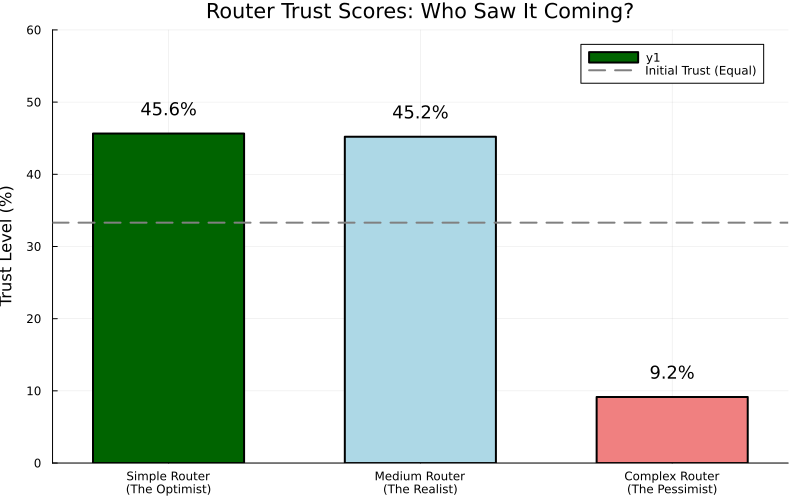

In [157]:
using Plots
using Printf
# using Distributions, Statistics  # keep if you still need them elsewhere

# Backend (GR is default; feel free to switch to plotlyjs(), pyplot(), etc.)
gr()

# Extract trust scores - remember the order: [complex, medium, simple]
trust_scores = result_joint.posteriors[:routing_strategy].p

# Prepare data
labels = ["Simple Router\n(The Optimist)",
          "Medium Router\n(The Realist)",
          "Complex Router\n(The Pessimist)"]
x = 1:3
y = trust_scores .* 100
colors = [:darkgreen, :lightblue, :lightcoral]

# Bar plot
bar(
    x, y;
    bar_width = 0.6,
    fillcolor = colors,
    linecolor = :black,       # outline like strokecolor
    linewidth = 2,
    xticks = (x, labels),
    ylim = (0, 60),
    ylabel = "Trust Level (%)",
    title = "Router Trust Scores: Who Saw It Coming?",
    legend = :topright,
    size = (800, 500)
)

# Reference line at 33.3% with legend entry
hline!([33.3]; color = :gray, linestyle = :dash, linewidth = 2, label = "Initial Trust (Equal)")

# Value labels above bars
for (i, yi) in enumerate(y)
    annotate!(i, yi + 2, text(@sprintf("%.1f%%", yi), 12, :center, :bottom))
end
plot!()



### The Verdict Makes Perfect Sense Now:
- **Complex Router (9.2% trust)**: "I told you to use GPT-4... I was wrong 87% of the time!" 💸
  - Started at 33%, crashed to 9%. The pessimist who always escalates got schooled by reality.
  
- **Medium Router (45.2% trust)**: "Sometimes you need complexity, mostly you don't" ⚖️
  - Up from 33%. Balanced approach proved wise.
  
- **Simple Router (45.6% trust)**: "I TOLD YOU HAIKU COULD DO IT!" 🎉
  - The optimist was right! Most of the tickets of that type were solved with simple models!

## Diving Deeper: What Each Router Learned

### Complex Router's Reality Check:

In [160]:
println(result_joint.posteriors[:θ_complex])

MixtureDistribution{Beta{Float64}, Float64}(Beta{Float64}[Beta{Float64}(α=3.5, β=20.0), Beta{Float64}(α=12.0, β=22.0)], [0.9878161423017022, 0.012183857698297733])


After seeing the data, we can conclude that our trust in the complex router was shattered.

In [161]:
println(result_joint.posteriors[:θ_simple])

MixtureDistribution{Beta{Float64}, Float64}(Beta{Float64}[Beta{Float64}(α=3.5, β=20.0), Beta{Float64}(α=4.0, β=20.5)], [0.5942229190339855, 0.4057770809660145])


The simple router was right all along, very trustful.

**The Vindication**: "I've been saying this all along! You don't need a sledgehammer for every nail!" 🏆

In [162]:
println(result_joint.posteriors[:θ_medium])

MixtureDistribution{Beta{Float64}, Float64}(Beta{Float64}[Beta{Float64}(α=3.5, β=20.0), Beta{Float64}(α=3.5, β=20.0)], [0.7, 0.3])


**The Balance**: "See? Most things are simple, but keep GPT-5 on speed dial for the 15% that aren't."

## The "Aha!" Moments

### Discovery #1: The 87/13 Rule

13.636363636363635

In [185]:
percentage_simple = round(sum(outcomes)/length(dataset)*100) 

14.0

In [187]:
println("🎯 The $(100 - percentage_simple)/$(percentage_simple*100) Rule for Banking Tickets:")
println("├─ $(100-percentage_simple)% can be solved with Haiku (\$0.03)")
println("└─ $(percentage_simple)% actually need GPT-5 (\$3.00)")
println("\n💰 Cost Impact:")
println("├─ Blind GPT-5 usage: \$300 per 100 tickets")
println("├─ Smart routing: ~\$42 per 100 tickets")
println("└─ Savings: 86%! (in this case)")

🎯 The 86.0/1400.0 Rule for Banking Tickets:
├─ 86.0% can be solved with Haiku ($0.03)
└─ 14.0% actually need GPT-5 ($3.00)

💰 Cost Impact:
├─ Blind GPT-5 usage: $300 per 100 tickets
├─ Smart routing: ~$42 per 100 tickets
└─ Savings: 86%! (in this case)


In [188]:
println("🧠 The Convergence Insight:\n")
println("All routers now agree: ~15% of tickets need complex models")
println("├─ Complex Router: 'I learned to stop panicking'")
println("├─ Medium Router: 'I was calibrated correctly'")
println("└─ Simple Router: 'I knew it all along!'")
println("\nBut we trust them differently based on their HISTORY:")
println("├─ Who was right most often? Simple & Medium")
println("└─ Who cost us money? Complex")

🧠 The Convergence Insight:

All routers now agree: ~15% of tickets need complex models
├─ Complex Router: 'I learned to stop panicking'
├─ Medium Router: 'I was calibrated correctly'
└─ Simple Router: 'I knew it all along!'

But we trust them differently based on their HISTORY:
├─ Who was right most often? Simple & Medium
└─ Who cost us money? Complex


In [ ]:
# Bayesian routing: Sample from learned posteriors to make decisions
# How that could look like:

# Helper to sample from MixtureDistribution (not natively supported)
sample_mixture(m::MixtureDistribution) = rand(m.components[rand(Categorical(m.weights))])

function route(posteriors, ticket_context)

    # here your logic to cluster tickets into a category

    # Sample which router to use
    router_idx = rand(posteriors[:routing_strategy])
    
    # Get complexity from selected router
    router_posteriors = [posteriors[:θ_complex], posteriors[:θ_medium], posteriors[:θ_simple]]
    complexity = sample_mixture(router_posteriors[router_idx])
    
    # Decision based on sampled complexity  
    model = complexity > 0.5 ? "complex" : "simple"
    
    return (model=model, complexity=complexity, router=router_idx)
end

# Use it
ticket = "I have been trying to transfer money to my other bank account for the last 10 days but it keeps failing. Can you help me?"

decision = route(result_joint.posteriors, ticket)
println("Route to $(decision.model)")

Route to simple


*These results brought to you by Bayes' Theorem: Teaching expensive AI models humility since 1763.*

*P.S. - The Complex Router is now in therapy, learning to let go of its need to overcomplicate everything. The Simple Router has been promoted to Chief Optimization Officer.*